# Check `PiecewiseQuaternion` Trajectory in Drake

Overarching goal is to take an *empirical* trajectory along $SO(3)$ 
(e.g. recorded from an input device), and compute the exact velocities and accelerations
to recover said trajectory.

This is mean to serve as a means for acausal filtering, to then compare against causal filtering.

Given other checks like those mentioned in `so2_so3_feedback.ipynb`, `sym_so3_notebook.ipynb`, hopefully easy to verify.

## Helper Stuff

In [1]:
import dataclasses as dc
from functools import partial
from importlib import reload

import matplotlib.pyplot as plt
import numpy as np
from numpy.linalg import norm

from pydrake.all import (
    PiecewiseQuaternionSlerp,
    Quaternion,
    RotationMatrix,
)

import trajectories as m
reload(m)
import so2_so3_helpers as m
reload(m)

from trajectories import (
    Coord,
    Mult,
    Sinusoid,
    So3,
    calc_rotational_values,
    make_rot_info_quat_sym,
    min_jerk,
)
from so2_so3_helpers import (
    integrate,
    maxabs,
    flatten,
    unflatten,
    cat,
    split,
    normalize,
    rot2d,
    rot2d_jac,
    so2_angle,
    skew,
    unskew,
    axang,
    axang3,
    axang3_dot,
    to_axang3,
    so3_dist,
    assert_so3,
)

quat_info = make_rot_info_quat_sym()

## Verify Basics

Let $\mathbb{Q} \subset \mathbb{R}^4$ denote unit quaternions.

Reconfirm arbitrary $SO(3)$ trajectory can be recovered via first-order integration along both $\mathbb{Q}$ and $SO(3)$.

In [2]:
num_r = quat_info.num_rot
num_R = 9

def scale(k, instant):
    x, xd, xdd = instant
    return (k * x, k * xd, k * xdd)

@dc.dataclass
class Instant:
    so: object
    coord: object

    def __iter__(self):
        return iter((self.so, self.coord))

def so3_traj(t):
    # SO(3) trajectory expressed as quaternion, rotation matrix, and
    # ang. vel. + acc.
    As = np.array([0.2, 0.6, 0.6, 0.5])
    func = Sinusoid(Ts=[1.0, 2.0, 3.0, 4.0], T0_ratios=[0, 0.125, 0.25, 0])
    func = Mult(func, min_jerk)
    dr, rd, rdd = scale(As, func(t))
    r = dr + quat_info.r0
    (R, w, wd), (r, rd, rdd) = calc_rotational_values(quat_info, r, rd, rdd)
    return Instant(So3(R, w, wd), Coord(r, rd, rdd))

In [3]:
def arccos_reflect(inner):
    inner = np.asarray(inner)
    inner_f = inner.reshape((-1,))
    meh = inner_f > 1
    inner_f[meh] = 2 - inner_f[meh]  # Reflect
    return np.arccos(inner)

def quat_dist(qa, qb):
    angle = 2 * arccos_reflect(qa.dot(qb))
    return angle

def largest_quat_dist(qs):
    # TODO(eric.cousineau): Would be nice to only compute triangle excl.
    # diagonal.
    angles = 2 * arccos_reflect(qs @ qs.T)
    return np.max(angles.flat)

In [4]:
# Basic stats about the traj in terms of angular vel.
# TODO(eric.cousineau): Dunno better way to check span of SO(3), so just gonna
# brute force pairwise distance. However, that doesn't give good sense of full
# coverage...
deg_max = 0.0
wn_max = 0.0
wdn_max = 0.0
ts = np.linspace(0, 10, 1000)
qs = []
for t in ts:
    so, coord = so3_traj(t)
    wn = norm(so.w)
    wn_max = max(wn, wn_max)
    wdn = norm(so.wd)
    wdn_max = max(wdn, wdn_max)
    qs.append(coord.r)
qs = np.asarray(qs)
deg_max = np.rad2deg(largest_quat_dist(qs))

print(qs.shape)
print(deg_max)
print(wn_max)
print(wdn_max)

(1000, 4)
167.98759694247187
5.796807764255272
23.319088763415795


Integrate along both $r(t)$ and $R(t)$ for world-fixed angular velocity. \
Ignore accel for now.

In [5]:
def proj_to_so3(R):
    return RotationMatrix.ProjectToRotationMatrix(R).matrix()

In [6]:
def to_q(r, R):
    return cat(r, flatten(R))

def from_q(q):
    r, R = split(q, (num_r, num_R))
    R = unflatten(R)
    return r, R

def calc_qd(t, q, *, check=False):
    r, R = from_q(q)
    so, coord = so3_traj(t)
    if check:
        assert_so3(R, tol=5e-5)
    R = proj_to_so3(R)
    rd = coord.rd
    Rd = skew(so.w) @ R
    if check:
        r_err = maxabs(r - coord.r)
        R_err = so3_dist(R, so.R)
        assert r_err < 1e-7, r_err
        assert R_err < 1e-4
        rd_via_w = quat_info.calc_rate_jacobian(coord.r) @ so.w
        rd_err = maxabs(rd - rd_via_w)
        assert rd_err < 1e-14
    qd = to_q(rd, Rd)
    return qd

so0, coord0 = so3_traj(0)
# print(so0)
q0 = to_q(coord0.r, so0.R)

# If this succeeds, then we met our desired tolerances.
integrate(
    q0, calc_qd, tf=3.0, pass_time=True, check=True,
)
print("All matches")

All matches


Now check `PiecewiseQuatnerion` by sampling along nodes of the spline.

If we sample sufficiently dense (small $dt$), then we should expect to recover original trajectory and derivatives.

Otherwise, we will expect some slop

In [7]:
def make_quat_traj(ts, rs):
    qs = [Quaternion(wxyz=r) for r in rs]
    return PiecewiseQuaternionSlerp(ts, qs)

def sample_traj(traj, t):
    R = RotationMatrix(traj.orientation(t)).matrix()
    w = traj.angular_velocity(t)
    # Zero :(
    wd = traj.angular_acceleration(t)
    assert np.all(wd == 0)
    return So3(R, w, wd)

In [8]:
tf = 3.0
# If dt is larger, then we have to relax our check of expected ang. vel.
dt = 0.005
# dt = 1.0

# Sample above trajectory.
ts = np.arange(0, tf + dt, dt)
rs = [so3_traj(t).coord.r for t in ts]
traj = make_quat_traj(ts, rs)

for t in ts:
    so, coord = so3_traj(t)
    sot = sample_traj(traj, t)
    assert so3_dist(so.R, sot.R) < 1e-7
    # Not the same, but we don't have same amt of info.
    w_err = maxabs(so.w - sot.w)
    if dt < 0.01:
        assert w_err < 5e-2, w_err 
    # print(w_err)

# Now try to smoothly integrate against the quaternion trajectory.

def to_q(R):
    return flatten(R)

def from_q(q):
    return unflatten(q)

def calc_qd(t, q, *, check=False):
    R = from_q(q)
    sot = sample_traj(traj, t)
    if check:
        assert_so3(R, tol=1e-4)
    R = proj_to_so3(R)
    if check:
        R_err = so3_dist(R, sot.R)
        # Yuck! This happens when blending for initial part.
        assert R_err < 3e-3
    w = sot.w
    Rd = skew(w) @ R
    qd = to_q(Rd)
    return qd

R0 = sample_traj(traj, 0).R
q0 = to_q(R0)
integrate(
    q0, calc_qd, tf=3.0, pass_time=True, check=True,
)
pass

## Angular Acceleration

As documented, the class using SLERP doesn't have angular acceleration, 'cause it's *linear* spherical interp. Derp. \
<https://github.com/RobotLocomotion/drake/blob/v1.13.0/common/trajectories/piecewise_quaternion.h#L108-L113>

Will just have to make acausal filter stuff.

In [9]:
from scipy import signal

In [10]:
def est_signals(ts, xs, *, filter, acc):
    dts = np.diff(ts).reshape((-1, 1))
    xds = np.diff(xs, axis=0) / dts
    z = np.zeros_like(xs[:1])
    xds = cat(z, xds)
    if filter is not None:
        xds = filter(xds)
    if not acc:
        return xds
    xdds = np.diff(xds, axis=0) / dts
    xdds = cat(z, xdds)
    if filter is not None:
        xdds = filter(xdds)
    return xds, xdds

def iir_discrete_lowpass(us, alpha):
    xs = np.zeros_like(us)
    xs[0] = us[0]
    for i in range(1, len(us)):
        xs[i] = alpha * us[i] + (1 - alpha) * xs[i - 1]
    return xs

def calc_alpha(dt, *, cutoff_freq):
    time_constant = 1 / (2 * np.pi * cutoff_freq)
    return dt / (dt + time_constant)

In [11]:
def linear_traj(t):
    As = np.array([1.0])
    func = Sinusoid(Ts=[1.0])
    func = Mult(func, min_jerk)
    r, rd, rdd = func(t)
    return r, rd, rdd

In [12]:
def make_noise_like(shape):
    if isinstance(shape, np.ndarray):
        shape = shape.shape
    assert isinstance(shape, tuple)
    # Lazy, meh.
    np.random.seed(0)
    # TODO(eric.cousineau): Provide noise of certain freq?
    return np.random.uniform(-1, 1, size=shape)

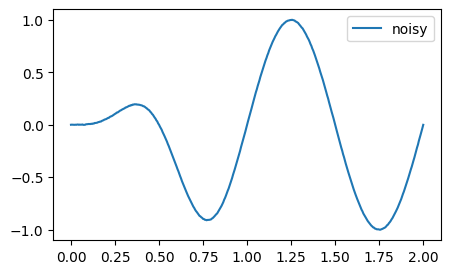

In [13]:
tf = 2.0
dt = 0.005
ts = np.arange(0, tf + dt, dt)

rs = []
rds = []
rdds = []
for t in ts:
    r, rd, rdd = linear_traj(t)
    rs.append(r)
    rds.append(rd)
    rdds.append(rdd)
rs, rds, rdds = map(np.asarray, (rs, rds, rdds))

noise = 0.5 * dt * make_noise_like(rs)
rns = rs + noise

plt.figure(figsize=(5, 3))
plt.plot(ts, rns, label="noisy")
# plt.plot(ts, rs, label="actual")
plt.legend()
pass

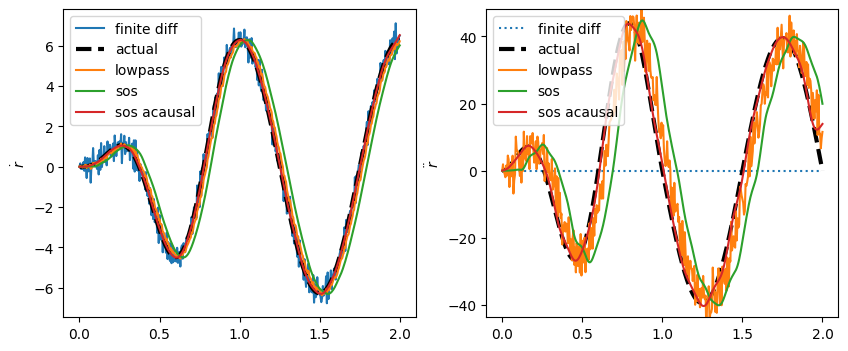

In [14]:
freq = 10
# TODO(eric.cousineau): Er, dunno how to compare frequencies, or actually
# do filter design.
sos = signal.butter(4, freq, fs=1 / dt, output="sos")
alpha = calc_alpha(dt, cutoff_freq=freq)

filt_lp = partial(iir_discrete_lowpass, alpha=alpha)
filt_sos = partial(signal.sosfilt, sos, axis=0)
filt_sos_acausal = partial(signal.sosfiltfilt, sos, axis=0)

rd_raw, rdd_raw = est_signals(ts, rns, filter=None, acc=True)
rd_lp, rdd_lp = est_signals(ts, rns, filter=filt_lp, acc=True)
rd_sos, rdd_sos = est_signals(ts, rns, filter=filt_sos, acc=True)
rd_sosa, rdd_sosa = est_signals(ts, rns, filter=filt_sos_acausal, acc=True)

_, axs = plt.subplots(ncols=2, figsize=(10, 4))
plt.sca(axs[0])
plt.plot(ts, rd_raw, label="finite diff")
plt.plot(ts, rds, "k--", linewidth=3, label="actual")
plt.plot(ts, rd_lp, label="lowpass")
plt.plot(ts, rd_sos, label="sos")
plt.plot(ts, rd_sosa, label="sos acausal")
plt.ylabel("$\dot{r}$")
plt.legend()

plt.sca(axs[1])
plt.plot(ts, 0 * rdd_raw, ":", label="finite diff")
plt.plot(ts, rdds, "k--", linewidth=3, label="actual")
# keep these limits
ylim = plt.ylim()
plt.plot(ts, rdd_lp, label="lowpass")
plt.plot(ts, rdd_sos, label="sos")
plt.plot(ts, rdd_sosa, label="sos acausal")
plt.ylabel("$\ddot{r}$")
plt.ylim(ylim)
plt.legend()
pass

## Try out SO(3) Trajectory Filtering

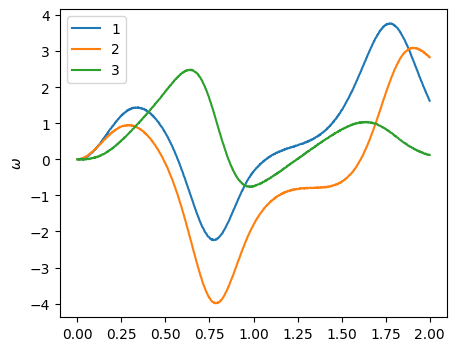

In [15]:
tf = 2.0
dt = 0.002
ts = np.arange(0, tf + dt, dt)

Rs = []
ws = []
wds = []
rs = []
rds = []
rdds = []
for t in ts:
    so, coord = so3_traj(t)
    Rs.append(so.R)
    ws.append(so.w)
    wds.append(so.wd)
    rs.append(coord.r)
    rds.append(coord.rd)
    rdds.append(coord.rdd)
(Rs, ws, wds, rs, rds, rdds) = map(np.asarray, (Rs, ws, wds, rs, rds, rdds))

np.random.seed(0)
# TODO(eric.cousineau): Provide noise of certain freq?
noise = 5 * dt * make_noise_like(ws)
wns = ws + noise

plt.figure(figsize=(5, 4))
plt.plot(ts, wns)
plt.ylabel("$\omega$")
plt.legend(list("123"))
pass

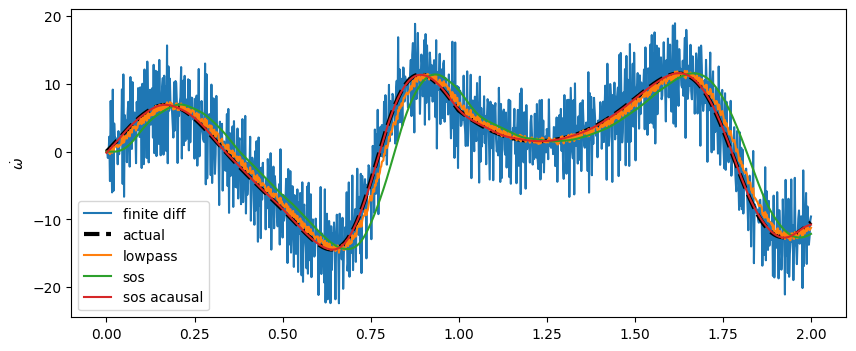

In [16]:
freq = 10
# TODO(eric.cousineau): Er, dunno how to compare frequencies, or actually
# do filter design.
sos = signal.butter(4, freq, fs=1 / dt, output="sos")
alpha = calc_alpha(dt, cutoff_freq=freq)

filt_lp = partial(iir_discrete_lowpass, alpha=alpha)
filt_sos = partial(signal.sosfilt, sos, axis=0)
filt_sos_acausal = partial(signal.sosfiltfilt, sos, axis=0)

wd_raw = est_signals(ts, wns, filter=None, acc=False)
wd_lp = est_signals(ts, wns, filter=filt_lp, acc=False)
wd_sos = est_signals(ts, wns, filter=filt_sos, acc=False)
wd_sosa = est_signals(ts, wns, filter=filt_sos_acausal, acc=False)

plt.figure(figsize=(10, 4))
plt.plot(ts, wd_raw[:, 0], label="finite diff")
plt.plot(ts, wds[:, 0], "k--", linewidth=3, label="actual")
plt.plot(ts, wd_lp[:, 0], label="lowpass")
plt.plot(ts, wd_sos[:, 0], label="sos")
plt.plot(ts, wd_sosa[:, 0], label="sos acausal")
plt.ylabel("$\dot{\omega}$")
plt.legend()
pass

**TODO(eric.cousineau)**: Errr... figure out something useful to do with this info.

At a minimum, the acausal seems 'aight?

### Try $C^2$ Interp on $\mathbb{R}^4$ w/ Projection to $\mathbb{Q}$

Reference:

- [HBI] Haarbach, Adrian, Tolga Birdal, and Slobodan Ilic. \
  “Survey of Higher Order Rigid Body Motion Interpolation Methods for Keyframe Animation and Continuous-Time Trajectory Estimation.” \
  In 2018 International Conference on 3D Vision (3DV), 381–89, 2018. \
  https://doi.org/10.1109/3DV.2018.00051 \
  [link to PDF](https://www.researchgate.net/publication/328312140_Survey_of_Higher_Order_Rigid_Body_Motion_Interpolation_Methods_for_Keyframe_Animation_and_Continuous-Time_Trajectory_Estimation)

See "Renormalized quatnerion Bézier curve (RQBez)", and the uber nice Fig. 4.

In [17]:
from pydrake.all import PiecewisePolynomial

In [18]:
def make_quat_traj_bezier(ts, rs):
    # Construct Bezier, but then have project back to coord. space.
    r_spline = PiecewisePolynomial.CubicWithContinuousSecondDerivatives(
        breaks=ts,
        samples=rs.T,
        periodic_end_condition=False,
    )
    rd_spline = r_spline.derivative()
    rdd_spline = rd_spline.derivative()

    def sample(t):
        r = r_spline.value(t)
        rd = rd_spline.value(t)
        rdd = rdd_spline.value(t)
        r, rd, rdd = quat_info.project_values(r, rd, rdd)
        return r, rd, rdd
    
    return sample

def quat_traj_values(traj, t):
    r, rd, rdd = traj(t)
    R, w, wd = quat_info.calc_values(r, rd, rdd)
    return Instant(So3(R, w, wd), Coord(r, rd, rdd))

In [19]:
# Try naive integration first against noiseless signal. Also, check out the
# ang. vel. and acc. values.

traj = make_quat_traj_bezier(ts, rs)

def to_q(r, rd, R, w):
    return cat(r, rd, flatten(R), w)

def from_q(q):
    r, rd, R, w = split(q, (num_r, num_r, num_R, 3))
    R = unflatten(R)
    return r, rd, R, w

def calc_qd(t, q, *, check=False):
    r_i, rd_i, R_i, w_i = from_q(q)
    if check:
        assert_so3(R_i, tol=1e-4)
        q_so3_err = maxabs(1 - norm(r_i))
        assert q_so3_err < 1e-5
    # Re-project
    R_i = proj_to_so3(R_i)
    r_i = normalize(r_i)
    # Expected.
    so, coord = quat_traj_values(traj, t)
    r_e, rd_e, rdd_e = coord
    R_e, w_e, wd_e = so
    if check:
        # Coord.
        r_err = quat_dist(r_i, r_e)
        assert r_err < 1e-4
        rd_err = maxabs(rd_i - rd_e)
        assert rd_err < 1e-4
        # SO(3).
        R_err = so3_dist(R_i, R_e)
        assert R_err < 1e-4
        w_err = maxabs(w_i - w_e)
        assert w_err < 1e-4
    # Derivatives.
    rdd_i = rdd_e
    Rd_i = skew(w_i) @ R_i
    wd_i = wd_e
    qd = to_q(rd_i, rdd_i, Rd_i, wd_i)
    return qd

so0, coord0 = quat_traj_values(traj, 0)
q0 = to_q(coord0.r, coord0.rd, so0.R, so0.w)
integrate(
    q0, calc_qd, tf=ts[-1], pass_time=True, check=True,
)
pass

Show what the naive spline $SO(3)$ trajectory looks like against the original $SO(3)$ trajectory.

In [20]:
def quat_to_rot(q):
    return RotationMatrix(Quaternion(wxyz=q)).matrix()

def rot_to_quat(R):
    return RotationMatrix(R).ToQuaternion().wxyz()

def naive_so3_finite_diff(qs, dt):
    count = len(qs)
    ws = np.zeros((count - 1, 3))
    for i in range(count - 1):
        Rp = quat_to_rot(qs[i])
        R = quat_to_rot(qs[i + 1])
        # Extrinsic plz, s.t. R = dR @ Rp
        dR = R @ Rp.T
        ws[i] = to_axang3(dR) / dt
    return ws

def naive_so3_euler_integ(q0, dt, ws):
    count = len(ws) + 1
    assert q0.shape == (4,)
    qs = np.zeros((count, 4))
    qs[0] = q0
    Rp = quat_to_rot(q0)
    for i in range(count - 1):
        dR = axang3(ws[i] * dt)
        R = dR @ Rp
        qs[i + 1] = rot_to_quat(R)
        Rp = R
    return qs

def add_ang_vel_to_quats(qs, dt, ws):
    count = len(qs)
    qns = []
    for qi, wi in zip(qs, ws, strict=True):
        Ri = quat_to_rot(qi)
        dRi = axang3(wi * dt)
        Rni = dRi @ Ri
        qni = rot_to_quat(Rni)
        qns.append(qni)
    return np.asarray(qns)

def filter_on_so3_via_quat(qs, dt, w_filter, *, first_zero=False):
    """
    Naively filter against quaternions using finite-differencing along SO(3).
    Probably what some of the survey papers mention.
    """
    ws_raw = naive_so3_finite_diff(qs, dt)
    if first_zero:
        ws_raw[0] = 0
    ws_filt = w_filter(ws_raw)
    ws_filt = ws_filt[:len(qs) - 1]
    qs_filt = naive_so3_euler_integ(qs[0], dt, ws_filt)
    return qs_filt

In [21]:
def compare_so3_derivs(
    ts, rs, Rs_gt, ws_gt, wds_gt, *, step_size=1,
):
    # Down-sample
    ts_ds = ts[::step_size]
    rs_ds = rs[::step_size]
    Rs_gt_ds = Rs_gt[::step_size]

    dt_est = np.mean(np.diff(ts_ds))

    # Plot angular velocities and accelerations via finite differencing
    # with the down-sampled timing.
    ts_diff = ts_ds
    dist_diff = [
        so3_dist(quat_to_rot(r), R) for (r, R) in zip(rs_ds, Rs_gt_ds)
    ]
    label_diff = "finite diff"
    ws_diff = naive_so3_finite_diff(rs_ds, dt_est)
    wds_diff = np.diff(ws_diff, axis=0) / dt_est
    # Repeat last few to maintain same shape.
    ws_diff = cat(ws_diff, ws_diff[-1:, :])
    wds_diff = cat(wds_diff, wds_diff[-2:, :])

    # Plot angular velocities and accelerations from the trajectory
    # for the originally sampled timing.
    traj = make_quat_traj_bezier(ts_ds, rs_ds)
    so_list = [quat_traj_values(traj, t).so for t in ts]
    ts_traj = ts
    dist_traj = [so3_dist(so.R, R) for (so, R) in zip(so_list, Rs_gt)]
    label_traj = "spline"
    ws_traj = [so.w for so in so_list]
    wds_traj = [so.wd for so in so_list]
    ws_traj, wds_traj = map(np.asarray, (ws_traj, wds_traj))

    print(f"  dt: {dt_est}")
    _, axs = plt.subplots(ncols=3, figsize=(15, 4))

    plt.sca(axs[0])
    plt.plot(ts_diff, dist_diff, label=label_diff)
    plt.plot(ts_traj, dist_traj, label=label_traj)
    plt.legend()
    plt.ylabel("Distance to Ground Truth\n$d(R, R_{gt})$ [rad]")

    plt.sca(axs[1])
    plt.plot(ts, ws_gt[:, 0], "k--", linewidth=2, label="ground truth")
    plt.plot(ts_diff, ws_diff[:, 0], label=label_diff)
    plt.plot(ts_traj, ws_traj[:, 0], label=label_traj)
    # plt.plot(ts, ws - ws_gt)
    plt.ylabel("$\omega_x$")
    plt.legend()

    plt.sca(axs[2])
    plt.plot(ts, wds_gt[:, 0], "k--", linewidth=2, label="ground truth")
    plt.plot(ts_diff, wds_diff[:, 0], label=label_diff)
    plt.plot(ts_traj, wds_traj[:, 0], label=label_traj)
    # plt.plot(ts, wds - wds_traj)
    plt.legend()
    plt.ylabel("$\dot{\omega_x}$")

    plt.show()

step_size: 1
  dt: 0.002


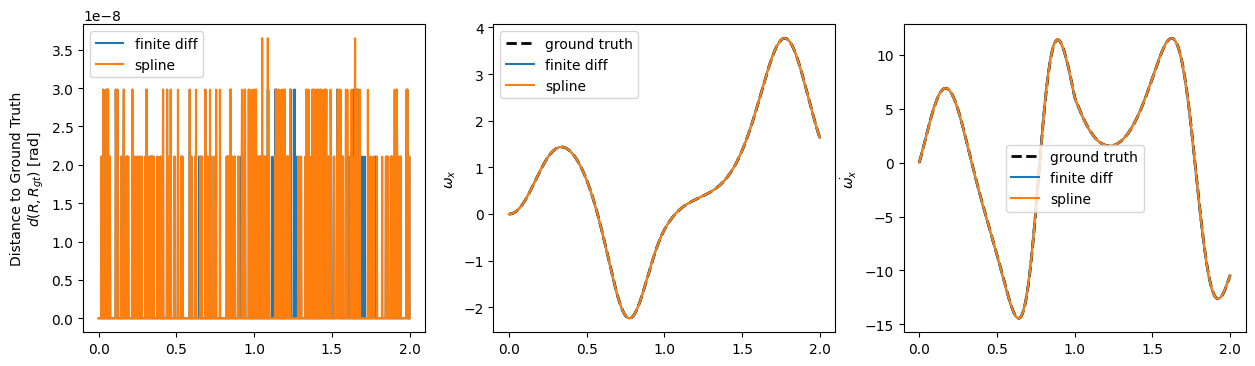

step_size: 50
  dt: 0.1


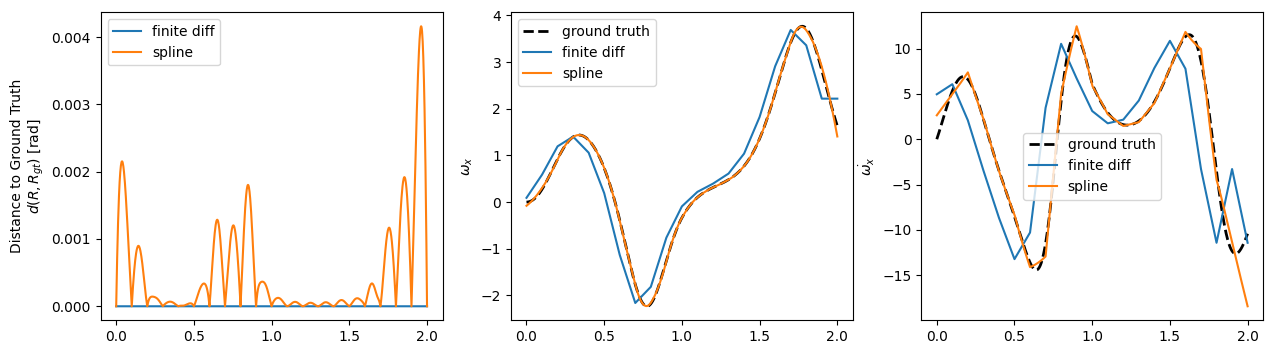

step_size: 100
  dt: 0.2


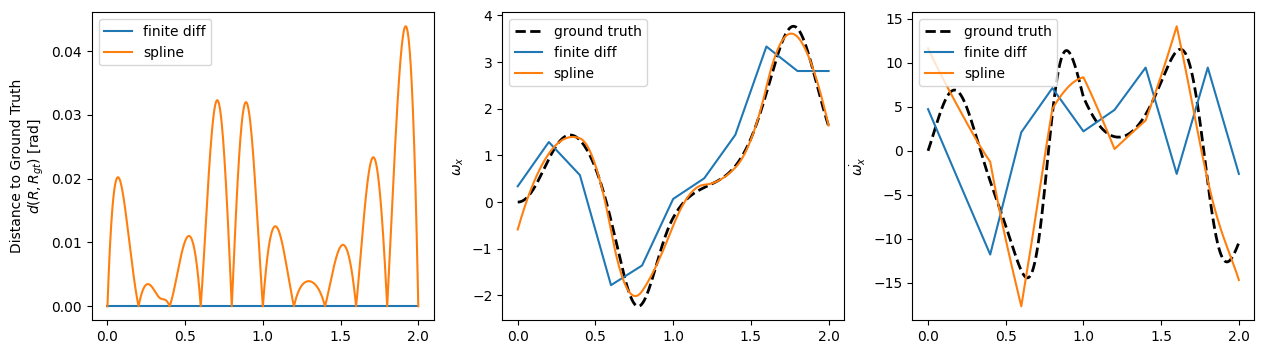

In [22]:
step_sizes = [1, 50, 100]
for step_size in step_sizes:
    print(f"step_size: {step_size}")
    compare_so3_derivs(
        ts, rs, Rs_gt=Rs, ws_gt=ws, wds_gt=wds, step_size=step_size
    )

Now try to see what this looks like when the trajectory has noise in $SO(3)$ injected into it.

Will conversion approach like MuJoCo's $SO(3)$ integrator, Drake's tests on `PiecewiseQuaternion`, etc. \
Generate angular velocities, then (world-frame / extrinsic, so pre-) multiply by $\text{Exp}(\omega\ dt)$.

Outta laziness, will haphazardly convert among spaces rather than do it (nicely) against quaternion as illustrated by stuff like [HBI].

In [23]:
# Quick test.
ws_est = naive_so3_finite_diff(qs, dt)
qs_est = naive_so3_euler_integ(qs[0], dt, ws_est)
assert maxabs(qs - qs_est) < 1e-14

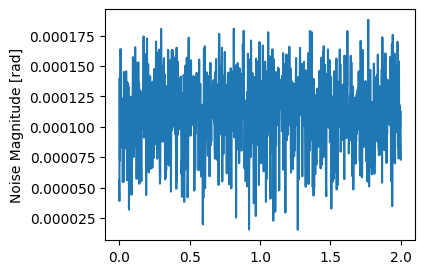

In [24]:
# Add noise and plot distance from original trajectory.

w_noise = 0.5 * dt * make_noise_like((len(rs), 3))
rns = add_ang_vel_to_quats(rs, dt, w_noise)

noise_mag = np.asarray([quat_dist(r, rn) for r, rn in zip(rs, rns)])
plt.figure(figsize=(4, 3))
plt.plot(ts, np.rad2deg(noise_mag))
plt.ylabel("Noise Magnitude [rad]")
pass

noisy, step_size: 1
  dt: 0.002


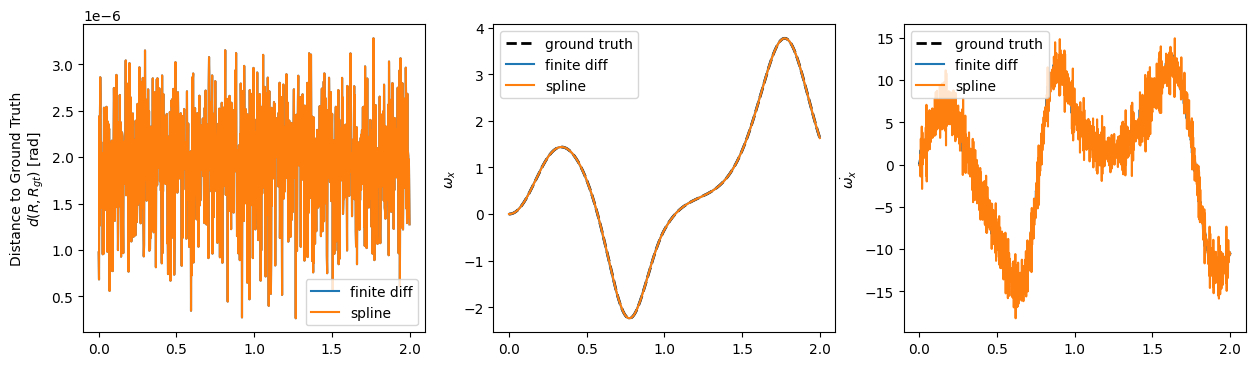

noisy, step_size: 50
  dt: 0.1


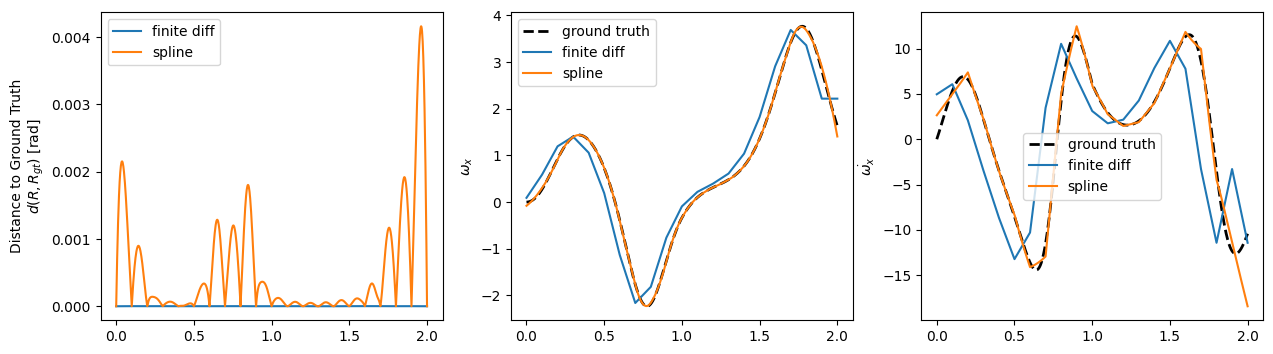

noisy, step_size: 100
  dt: 0.2


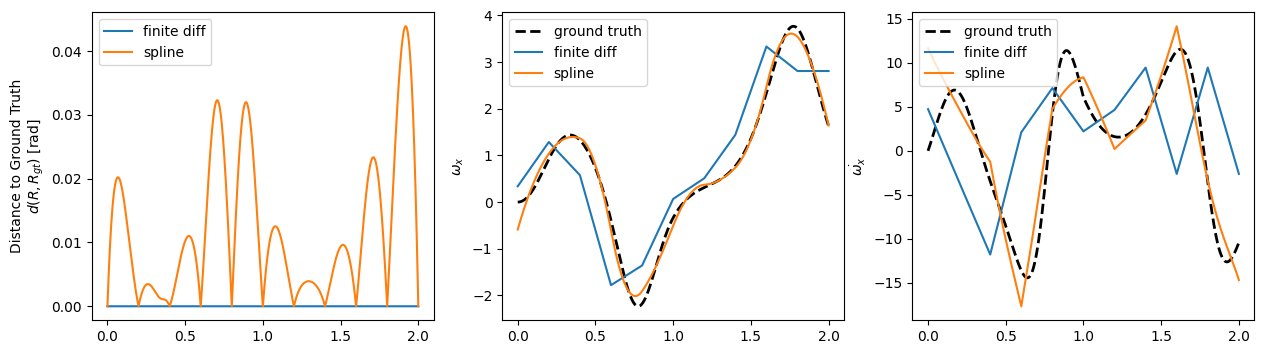

In [25]:
step_sizes = [1, 50, 100]
for step_size in step_sizes:
    print(f"noisy, step_size: {step_size}")
    compare_so3_derivs(
        ts, rns, Rs_gt=Rs, ws_gt=ws, wds_gt=wds, step_size=step_size,
    )

filt: nothing
  dt: 0.002


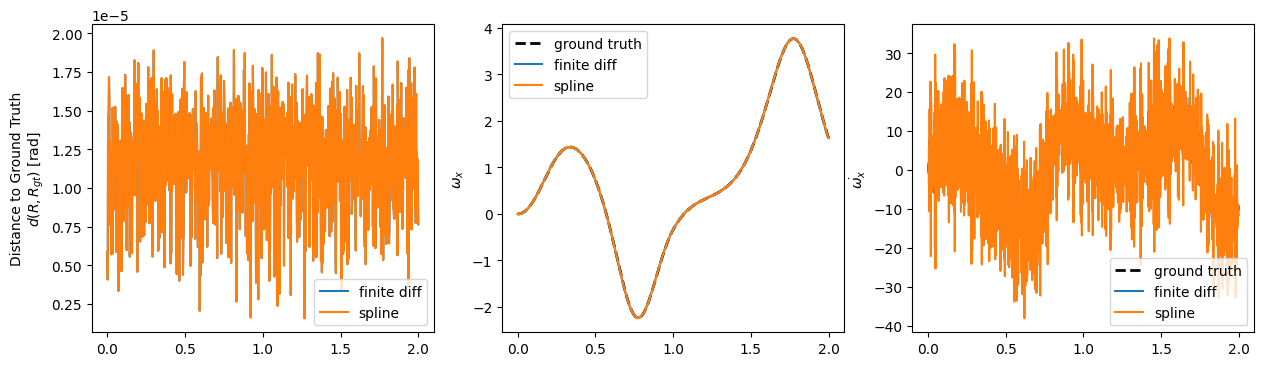

filt: lp
  dt: 0.002


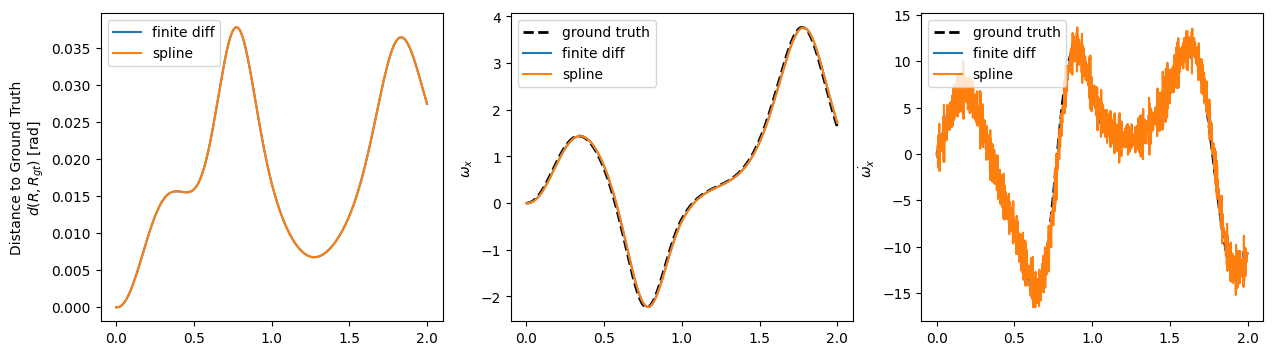

filt: sos
  dt: 0.002


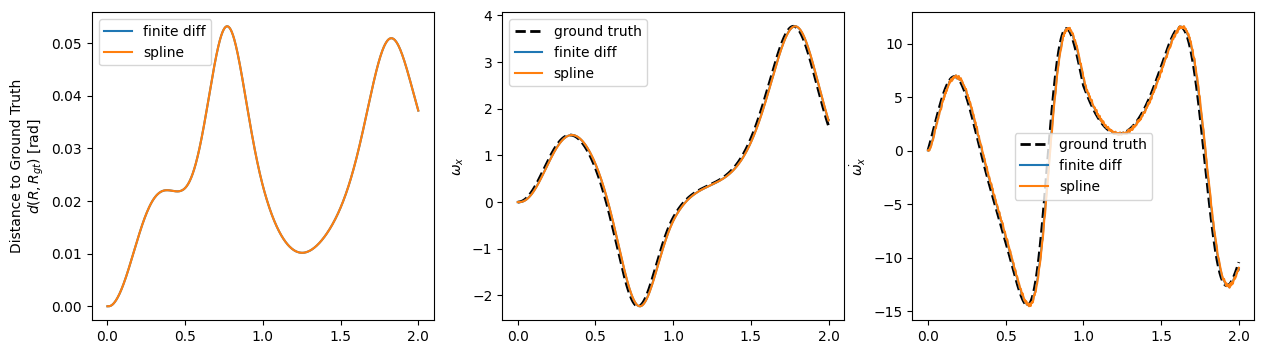

filt: sos_acausual
  dt: 0.002


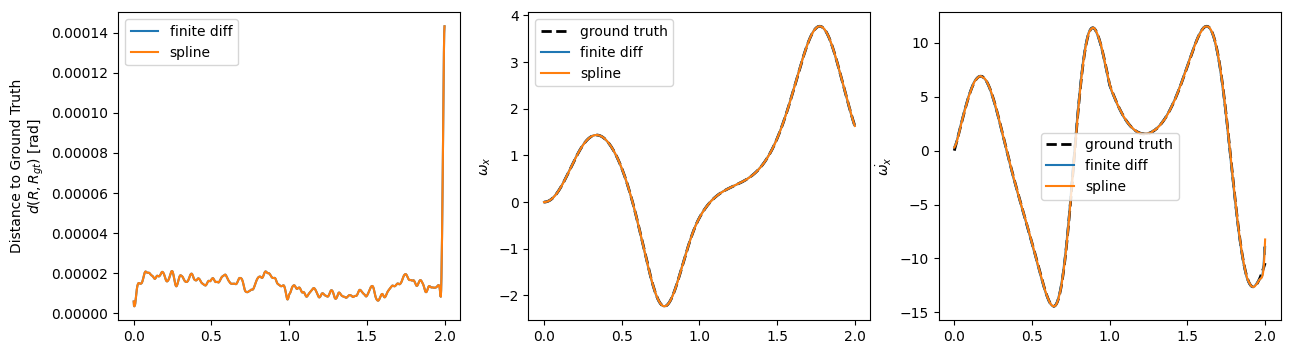

In [26]:
w_noise = 3.0 * dt * make_noise_like((len(rs), 3))
rns = add_ang_vel_to_quats(rs, dt, w_noise)

freq = 20
# See above - dunno what I'm doing for real filter design.
sos = signal.butter(2, freq, fs=1 / dt, output="sos")
alpha = calc_alpha(dt, cutoff_freq=freq)

filt_map = dict(
    nothing=None,
    lp=partial(iir_discrete_lowpass, alpha=alpha),
    sos=partial(signal.sosfilt, sos, axis=0),
    sos_acausual=partial(signal.sosfiltfilt, sos, axis=0),
)

step_size = 1
for name, filt in filt_map.items():
    print(f"filt: {name}")
    if filt is None:
        rns_filt = rns
    else:
        rns_filt = filter_on_so3_via_quat(
            rns, dt, w_filter=filt, first_zero=True
        )
    compare_so3_derivs(
        ts, rns_filt, Rs_gt=Rs, ws_gt=ws, wds_gt=wds,
    )

**Prelim Empirical Conclusion**

For recording a possibly noisy trajectory from a device, but then having a filtered and consistent version,
should maybe avoid using acausal filtering for now (until I learn how to tune it).

Instead, do simple finite-difference + discrete low-pass filtering, reintegrate, and use the fully filtered
trajectory. Can attach spline to trajectory, assuming high-frequency stuff is mostly gone.

**TODO(eric.cousineau)**: Why does acausal filtfilt have such a weird vel / acc spike at end? (and a lil at beginning?)

**TODO(eric.cousineau)**: Would using B-spline SO(3) stuff help serve as natural filtering mechanism?